In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from football_modelling.plotting import createPitch
import json
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
%load_ext autoreload
%autoreload 2

/Users/thomas/.pyenv/versions/3.10.0/envs/soccer/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
#Function for finding passes before shot
shot_window = 15    
def in_range(pass_time,start,finish):
        return (True in ((start < pass_time) & (pass_time < finish)).unique())

In [4]:
#Size of the pitch in yards (!!!)
pitchLengthX=120
pitchWidthY=80
competition_id = 72

In [6]:
from dotenv import load_dotenv, find_dotenv
dotenv_location = find_dotenv()
load_dotenv(dotenv_location)
data_dir = Path(os.path.expanduser(os.getenv("DATA_ROOT_DIR")))
statsbomb_dir = data_dir.joinpath('open-data/data')
matches_dir = statsbomb_dir.joinpath(f'matches/{competition_id}/30.json')
with open(matches_dir) as f:
    matches = json.load(f)

In [7]:
#Get all the teams and match_ids
teams=[]
match_ids=[]
for match in matches:
    if not(match['home_team']['home_team_name'] in teams):
        teams = teams + [match['home_team']['home_team_name']]
    if not(match['away_team']['away_team_name'] in teams):
        teams = teams + [match['away_team']['away_team_name']]

    match_ids=match_ids + [match['match_id']]

In [8]:
#Collect passes and shots for all players.
passshot_df = pd.DataFrame(None)
passshot_df = pd.DataFrame(columns=['Team','Passes','Shots','Goals','Matches','Danger Passes'])
danger_passes_by=dict()
number_of_matches=dict()
for match in matches:
    match_id=match['match_id']
    file_name=str(match_id)+'.json'
    with open(statsbomb_dir.joinpath('events').joinpath(file_name)) as data_file:
        data = json.load(data_file)
    dfall = json_normalize(data, sep = "_").assign(match_id = file_name[:-5])
    
    # print(match['home_team']['home_team_name'] + ' vs ' + match['away_team']['away_team_name'])
    
    #Home team
    for theteam in [match['home_team']['home_team_name'],match['away_team']['away_team_name']]:
        team_actions = (dfall['team_name']==theteam)
        df = dfall[team_actions]
        #A dataframe of passes
        passes_match = df.loc[df['type_name'] == 'Pass'].set_index('id')
        #A dataframe of shots
        shots_match = df.loc[df['type_name'] == 'Shot'].set_index('id')

        #Find passes within 15 seconds of a shot, exclude corners.
        shot_times = shots_match['minute']*60+shots_match['second']
        shot_start = shot_times - shot_window
        pass_times = passes_match['minute']*60+passes_match['second']
        pass_to_shot = pass_times.apply(lambda x: in_range(x,shot_start,shot_times))
        iscorner = passes_match['pass_type_name']=='Corner'
        danger_passes=passes_match[np.logical_and(pass_to_shot,np.logical_not(iscorner))]
        if theteam in danger_passes_by:
            danger_passes_by[theteam]= danger_passes_by[theteam].append(danger_passes)
            number_of_matches[theteam]=number_of_matches[theteam]+1
        else:
            danger_passes_by[theteam]= danger_passes
            number_of_matches[theteam]=1
            
        if theteam==match['home_team']['home_team_name']:
            goalsscored=match['home_score']
        else:
            goalsscored=match['away_score']
            
        passshot_df = passshot_df.append({
                    "Team": theteam,
                    "Passes": len(passes_match),
                    "Shots": len(shots_match),
                    "Goals": goalsscored,
                    "Danger Passes": len(danger_passes)
                    },ignore_index=True)       

/var/folders/tj/210mgsf94f51kmvjq04yb70c0000gn/T/ipykernel_74474/3442155683.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dfall = json_normalize(data, sep = "_").assign(match_id = file_name[:-5])


In [9]:
passshot_df

,Team,Passes,Shots,Goals,Matches,Danger Passes
0,Jamaica Women's,267,10,1,NaN,12
1,Australia Women's,704,11,4,NaN,27
2,Norway Women's,576,32,1,NaN,70
3,Australia Women's,671,20,1,NaN,44
4,Australia Women's,495,16,1,NaN,26
...,...,...,...,...,...,...
99,Sweden Women's,501,11,0,NaN,8
100,Italy Women's,297,6,0,NaN,24
101,Netherlands Women's,501,20,2,NaN,52
102,Spain Women's,368,4,1,NaN,7


Text(0, 0.5, 'Shots (y)')

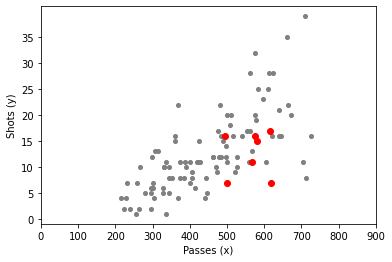

In [10]:
fig,ax=plt.subplots(num=1)
ax.plot('Passes','Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')
team_of_interest="United States Women's"
team_of_interest="England Women's"
team_of_interest_matches=(passshot_df['Team']==team_of_interest)
ax.plot('Passes','Shots', data=passshot_df[team_of_interest_matches], linestyle='none', markersize=6, marker='o', color='red')
ax.set_xticks(np.arange(0,1000,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')

In [11]:
passshot_df['Shots']= pd.to_numeric(passshot_df['Shots']) 
passshot_df['Passes']= pd.to_numeric(passshot_df['Passes']) 
passshot_df['Goals']= pd.to_numeric(passshot_df['Goals']) 

In [12]:
passshot_df

,Team,Passes,Shots,Goals,Matches,Danger Passes
0,Jamaica Women's,267,10,1,NaN,12
1,Australia Women's,704,11,4,NaN,27
2,Norway Women's,576,32,1,NaN,70
3,Australia Women's,671,20,1,NaN,44
4,Australia Women's,495,16,1,NaN,26
...,...,...,...,...,...,...
99,Sweden Women's,501,11,0,NaN,8
100,Italy Women's,297,6,0,NaN,24
101,Netherlands Women's,501,20,2,NaN,52
102,Spain Women's,368,4,1,NaN,7


In [13]:
#Fit the model
model_fit=smf.ols(formula='Shots ~ Passes', data=passshot_df[['Shots','Passes']]).fit()
print(model_fit.summary())        
b=model_fit.params
x=np.arange(0,1000,step=0.5)
y=b[0]+b[1]*x
ax.plot( x,y, linestyle='-', color='black')
ax.set_ylim(0,40)
ax.set_xlim(0,800) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
fig.savefig('Output/ShotsPassesWithFit.pdf', dpi=None, bbox_inches="tight") 

                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     89.21
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           1.38e-15
Time:                        17:23:33   Log-Likelihood:                -321.84
No. Observations:                 104   AIC:                             647.7
Df Residuals:                     102   BIC:                             653.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7636      1.916     -2.486      0.0

In [14]:

#For goals (and strictly speaking even for shots) it is better to do a Poisson regression
poisson_model = smf.glm(formula="Goals ~ Passes + Team", data=passshot_df,
                    family=sm.families.Poisson()).fit()
poisson_model.summary()
b=poisson_model.params

In [15]:
#Make comparative pass maps
x_all=[]
y_all=[]
H_Pass=dict()
for team in teams:
    dp=danger_passes_by[team]
    print(f"{team}: {str(len(dp))}")
    
    x=[]
    y=[]
    for i,apass in dp.iterrows():
        x.append(apass['location'][0])
        y.append(pitchWidthY-apass['location'][1])

    #Make a histogram of passes
    H_Pass[team]=np.histogram2d(y, x,bins=5,range=[[0, pitchWidthY],[0, pitchLengthX]])
    
    x_all = x_all+x
    y_all = y_all+y

H_Pass_All=np.histogram2d(y_all, x_all,bins=5,range=[[0, pitchWidthY],[0, pitchLengthX]])

Jamaica Women's: 48
Australia Women's: 133
Norway Women's: 149
Italy Women's: 116
Argentina Women's: 42
Japan Women's: 155
United States Women's: 321
Thailand Women's: 30
Chile Women's: 95
Sweden Women's: 238
Nigeria Women's: 61
Korea Republic Women's: 108
Germany Women's: 165
Spain Women's: 178
South Africa Women's: 36
China PR Women's: 104
Scotland Women's: 52
Netherlands Women's: 239
Cameroon Women's: 96
Canada Women's: 160
New Zealand Women's: 41
England Women's: 231
France Women's: 199
Brazil Women's: 83


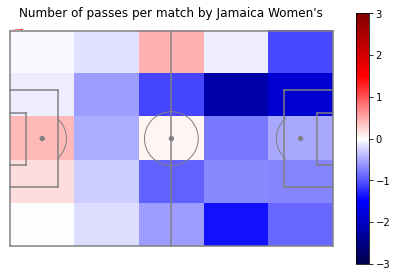

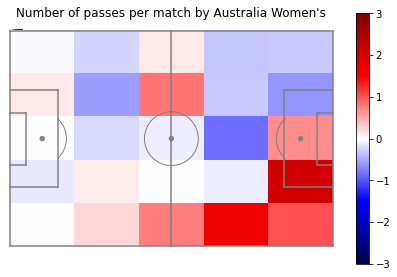

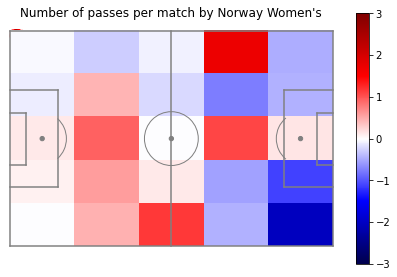

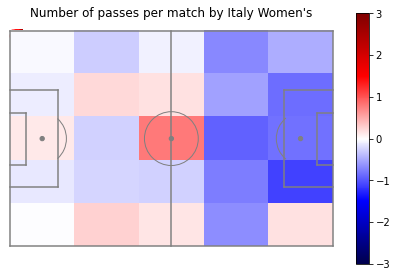

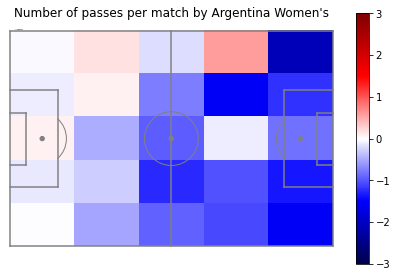

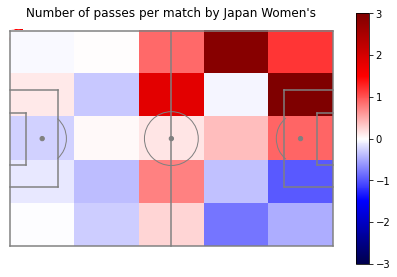

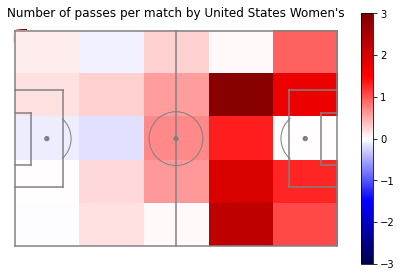

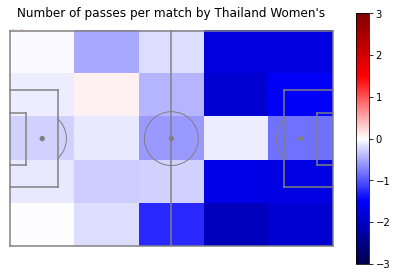

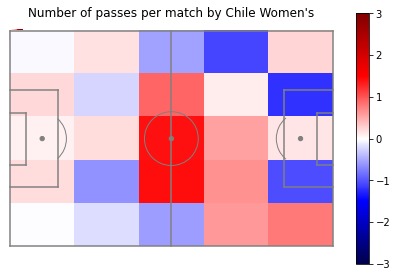

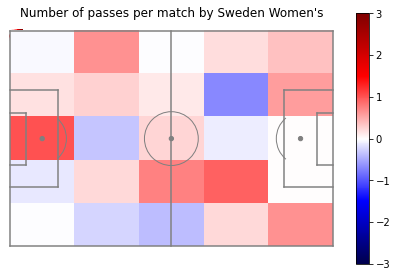

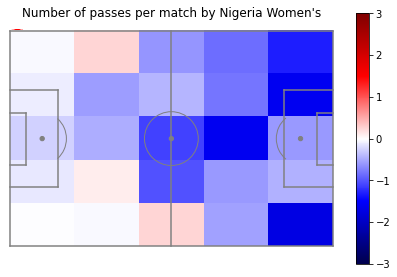

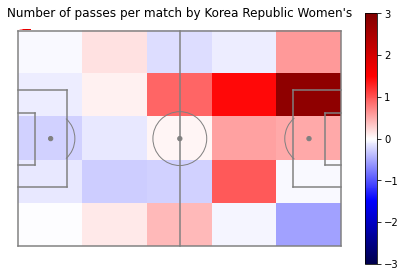

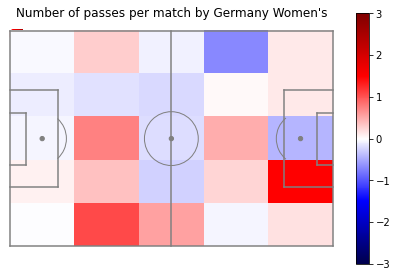

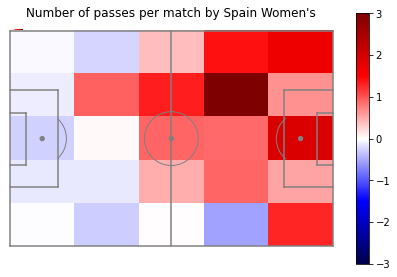

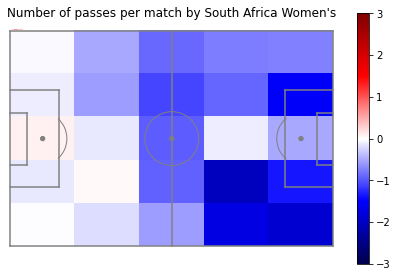

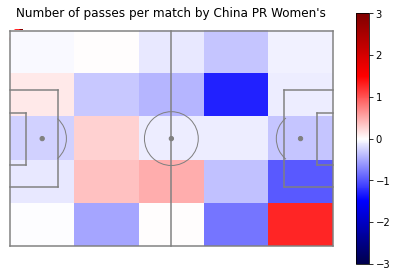

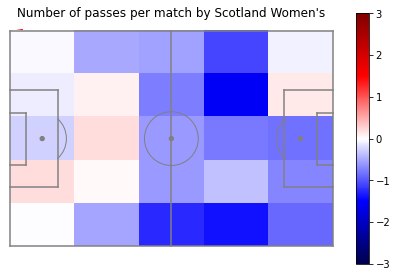

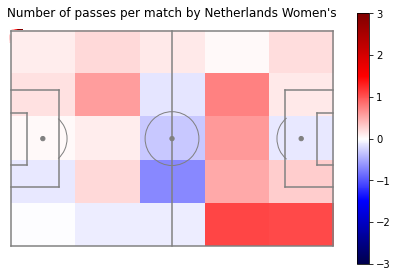

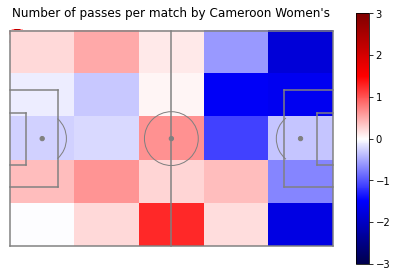

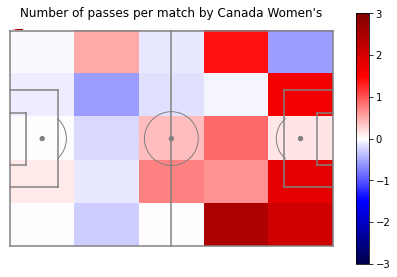

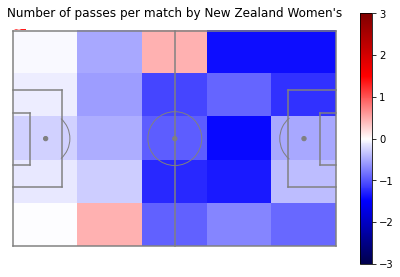

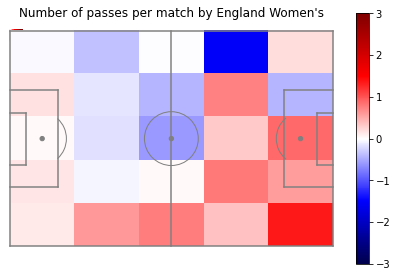

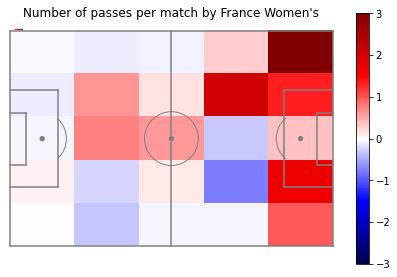

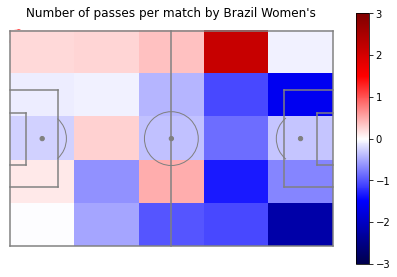

In [16]:
for team in teams:
    (fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
    pos=ax.imshow(H_Pass[team][0]/number_of_matches[team], aspect='auto',cmap=plt.cm.seismic,vmin=-3, vmax=3)
    pos=ax.imshow(H_Pass[team][0]/number_of_matches[team] - H_Pass_All[0]/(len(matches)*2), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.seismic,vmin=-3, vmax=3)
    #pos=ax.imshow(H_Pass[team][0]/number_of_matches[team] / (H_Pass_All[0]/(len(matches)*2)), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.seismic,vmin=0.5, vmax=2)
    
    ax.set_title('Number of passes per match by ' +team)
    plt.xlim((-1,121))
    plt.ylim((83,-3))
    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    fig.colorbar(pos, ax=ax)
    plt.show()
    
    fig.savefig('Output/PassHeat' + team+ '.pdf', dpi=None, bbox_inches="tight") 